In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import sqlite3
import os
import numpy as np
import shutil
import math
import seaborn as sns
import matplotlib.pyplot as plt
import operator


In [2]:
#creating files folders.
import os
if not os.path.exists('./mta_data'):
    os.makedirs('./mta_data')
if not os.path.exists('./mta_data_copy'):
    os.makedirs('./mta_data_copy')
if not os.path.exists('./mta_cleaned'):
    os.makedirs('./mta_cleaned')

## web scarping data from original data set(need uncomment to run)

In [ ]:
'''
mta_web='http://web.mta.info/developers/turnstile.html'
response=requests.get(mta_web)
web_content=response.content
soup = BeautifulSoup(web_content, 'html.parser')
final_link=[]
for link in soup.find_all('a',{'href':re.compile('data/nyct/turnstile+')}):
    temp_link='http://web.mta.info/developers/'+link.get('href')
    final_link.append(temp_link)
for link in final_link:
    file_name=re.sub('http://web.mta.info/developers/data/nyct/turnstile/','',link)
    response=requests.get(link)
    with open('./mta_data/'+file_name, 'wb') as f:
        print(file_name)
        f.write(response.content)
'''  

#### copy our data to some backup folders

In [ ]:
for root, dirs, files in os.walk('./mta_data/'):
    file_list=files
data_directory_list=['./mta_data/'+x for x in file_list]
for data in data_directory_list:
    shutil.copy(data,'./mta_data_copy/')

### first clean our data prior to 2014-10-18

clean our data bad lines which has abnormal length which are greater than 43 columns.And fill the rows which do not have 43 columns with empty values nan.


In [ ]:
def check_bad_line(data_directory):
    
    
    output_directory=re.sub('./mta_data','./mta_cleaned',data_directory)
    with open(output_directory, 'w') as f:
        oversized=1
        with open(data_directory) as fp:   
            lines=fp.readlines()
            for line in lines:
                line_split=line.split(',')
                original_line=line.strip()
                comma_len=43-len(line_split)
                if comma_len<0:
                    oversized=oversized+1
                    continue
                if comma_len>0:
                    final_line=''.join([line.strip(),','*comma_len, '\n'])
                else:
                    final_line=line
                f.write(final_line)
            if oversized>1:
                print(data_directory,oversized)

In [ ]:
for root, dirs, files in os.walk('./mta_data/'):
    file_list=files
data_directory_list=['./mta_data/'+x for x in file_list]
for data in data_directory_list:
    if data<'./mta_data/turnstile_141018.txt':
        check_bad_line(data)     
    else:
        shutil.copy(data,'./mta_cleaned/')
   

## Second cleaning and create a database to store our data

In [ ]:
                 
def clean_df_43(df):
    '''
    input dataframe
    output cleaned dataframe
    '''
    temp_index=list(range(8,48,5))
    begin_index=temp_index[0:-1]
    end_index=temp_index[1:]
    header_data=df.iloc[:,[0,1,2]]
    final_data=df.iloc[:,list(range(0,8))]
    column_name=['CA','UNIT','SCP','DATE','TIME','DESC','ENTRIES','EXITS']
    final_data.columns=column_name
    for i in range(len(begin_index)):
        temp_data=df.iloc[:,list(range(0,3))+list(range(begin_index[i],end_index[i]))]
        temp_data.columns=column_name
        final_data=pd.concat([final_data, temp_data], axis=0, ignore_index=True)
    final_data=final_data.dropna(axis=0,thresh=5)
    #### use regex match to see if we have some rows mismatched with target column type. for example, the DATE column would be 
    #### format as 'YYYY-MM-DD' and the CA format would be 'A002' something like this.
    #### we would return the total bad rows counts' if it is less than 10,we would automatically cleared the bad rows. Otherwise,
    #### we would report the data directory and investigate by ourselves mannually.
    final_data['DATE']=[str(x) for x in final_data['DATE']]
    final_data['DATE']=['20'+x[6:8]+'-'+x[0:5] for x in final_data['DATE']]
    final_data['UNIT']=final_data['UNIT'].astype(str)
    final_data['CA']=final_data['CA'].astype(str)
    final_data['DATE']=final_data['DATE'].astype(str)
    final_data['TIME']=final_data['TIME'].astype(str)
    unit_index=final_data['UNIT'][~final_data['UNIT'].str.match('R[0-9]{3}')].index.tolist()
    ca_index=final_data['CA'][~final_data['CA'].str.match('[A-Z]+[0-9]+')].index.tolist()
    date_index=final_data['DATE'][~final_data['DATE'].str.match('[0-9]{4}-[0-9]{2}-[0-9]{2}')].index.tolist()
    time_index=final_data['TIME'][~final_data['TIME'].str.match('[0-9]{2}:[0-9]{2}:[0-9]{2}')].index.tolist()
    bad_index=[ca_index,unit_index,date_index,time_index]
    bad_index=list(set().union(*bad_index))
    if len(bad_index)<100:
        print(len(bad_index))
        final_data=final_data.drop(bad_index)
    else:
        print(final_data['DATE'][0],'NEED BE CHECKED AGAIN')
    return(final_data)

def clean_df(df):
    '''
    input dataframe
    output cleaned dataframe
    '''
    original_column_name=list(df.columns)
    original_column_name[0]='CA'
    original_column_name[-1]='EXITS'
    df.columns=original_column_name
    df=df.drop(['STATION','LINENAME','DIVISION'],axis=1)
    df['DATE']=[re.sub('/','-',x) for x in df['DATE']]
    df['DATE']=[x[6:]+'-'+x[0:5] for x in df['DATE']]
     #### use regex match to see if we have some rows mismatched with target column type. for example, the DATE column would be 
    #### format as 'YYYY-MM-DD' and the CA format would be 'A002' something like this.
    #### we would return the total bad rows counts' if it is less than 10,we would automatically cleared the bad rows. Otherwise,
    #### we would report the data directory and investigate by ourselves mannually.
    df['UNIT']=df['UNIT'].astype(str)
    df['CA']=df['CA'].astype(str)
    df['DATE']=df['DATE'].astype(str)
    df['TIME']=df['TIME'].astype(str)
    unit_index=df['UNIT'][~df['UNIT'].str.match('R[0-9]{3}')].index.tolist()
    ca_index=df['CA'][~df['CA'].str.match('[A-Z]+[0-9]+')].index.tolist()
    date_index=df['DATE'][~df['DATE'].str.match('[0-9]{4}-[0-9]{2}-[0-9]{2}')].index.tolist()
    time_index=df['TIME'][~df['TIME'].str.match('[0-9]{2}:[0-9]{2}:[0-9]{2}')].index.tolist()
    bad_index=[ca_index,unit_index,date_index,time_index]
    bad_index=list(set().union(*bad_index))
    if len(bad_index)<100:
        print(len(bad_index))
        df=df.drop(bad_index)
    else:
        print(df['DATE'][0],'NEED BE CHECKED AGAIN')
    return df

       
        
                    

In [ ]:
#drop table for testing
c = conn.cursor()
c.execute('drop table mta_before')
c.execute('drop table mta')

In [ ]:
c.execute('''CREATE TABLE mta_before
            (CA VARCHAR, UNIT VARCHAR, SCP VARCHAR, DATE VARCHAR,
            TIME VARCHAR,DESC VARCHAR,ENTRIES MEDIUMINT,EXITS MEDIUMINT)''')
conn.commit()

In [ ]:
#clean our data directory list
for root, dirs, files in os.walk('./mta_cleaned//'):
    file_list=files
data_directory_list=['./mta_cleaned/'+x for x in file_list]
for data_directory in data_directory_list:  
    if data_directory>='./mta_cleaned/turnstile_141018.txt':
        print(data_directory)
        temp_data=pd.read_table(data_directory,sep=',')
        temp_cleaned_data=clean_df(temp_data)
        try:
            temp_cleaned_data.to_sql('mta_before', conn, if_exists='append', index=False)
        except:
            print(data_directory)
    else:
    #elif data_directory>='./mta_cleaned/turnstile_120505.txt':
        print(data_directory)
        temp_data=pd.read_table(data_directory,sep=',',header=None)
        temp_cleaned_data=clean_df_43(temp_data)
        try:
            temp_cleaned_data.to_sql('mta_before', conn, if_exists='append', index=False)
        except:
            print(data_directory)


    

In [147]:
conn = sqlite3.connect('mta.db')
c = conn.cursor()

In [373]:
station_name=pd.read_excel('./Remote-Booth-Station.xls')

In [403]:
station_name.columns=['UNIT','CA','Station','Line Name','Division']
station_name=station_name.loc[:,['UNIT','CA','Station']]

## Q1 Which station has most UNIT

testing sample

In [169]:
for row in c.execute('''SELECT UNIT,COUNT(DISTINCT SCP)
                        FROM mta_before
                        GROUP BY UNIT
                        ORDER BY count(DISTINCT SCP) DESC
                        LIMIT 5 
                        '''):
        print(row)

('R540', 100)
('R549', 83)
('R014', 67)
('R028', 59)
('R057', 55)


## Q2 Total entries and exits in Feb-02-01

In [ ]:
station_sql='''SELECT *
               FROM mta_before
               WHERE DATE=='2013-02-01'

   '''

station=pd.read_sql(station_sql,conn)

In [170]:
def get_entries(df):
    df=df.sort_values(['TIME'])
    entries=df['ENTRIES']
    exits=df['EXITS']
    entrie_diff=np.diff(entries)
    entrie_normality=(entrie_diff>=-20).all()
    exit_diff=np.diff(exits)
    exit_normality=(exit_diff>=-20).all()  
    if entrie_normality&exit_normality:
        entrie_diff=entrie_diff[entrie_diff>0]
        exit_diff=exit_diff[exit_diff>0]
        return sum(entrie_diff),sum(exit_diff)
    else:
        entrie_diff=entrie_diff[entrie_diff>0]
        exit_diff=exit_diff[exit_diff>0]
        entrie_diff=entrie_diff[abs(entrie_diff)<=10000]
        exit_diff=exit_diff[abs(exit_diff)<=10000]
        return sum(entrie_diff),sum(exit_diff)
new_df=station.groupby(['CA','UNIT','SCP','DATE']).apply(get_entries).reset_index()
new_df.columns=['CA','UNIT','SCP','DATE','entrie&exit']
new_df['busy']=[x[0]+x[1] for x in new_df['entrie&exit']]
print('total entrie and exits in Feb-02-01',new_df['busy'].sum())


9701046


## Q3 Most busy station in 2013-02-01.

In [381]:

new_df=station.groupby(['CA','UNIT','SCP','DATE']).apply(get_entries).reset_index()
new_df.columns=['CA','UNIT','SCP','DATE','entrie&exit']
new_df['busy']=[x[0]+x[1] for x in new_df['entrie&exit']]

In [382]:
new_df=new_df.groupby(['CA','UNIT'])['busy'].sum().reset_index()
new_df.head(2)

,CA,UNIT,busy
0,A002,R051,22558
1,A006,R079,8406


In [404]:
pd.merge(new_df, station_name,  how='left', left_on=['CA','UNIT'], right_on = ['CA','UNIT']).sort_values('busy',ascending=False)[0:10]

,CA,UNIT,busy,Station
548,R238,R046,134762,42 ST-GRD CNTRL
428,PTH08,R540,77766,PATH WTC
673,R533,R055,76297,MAIN ST
549,R240,R047,76002,42 ST-GRD CNTRL
471,R138,R293,75105,34 ST-PENN STA
533,R221,R170,65427,14 ST-UNION SQ
561,R249,R179,62707,86 ST
216,N063A,R011,62352,42 ST-PA BUS TE
322,N324,R018,61701,ROOSEVELT AVE
361,N500,R020,61275,47-50 ST-ROCK


In [166]:
print(new_df.groupby(['UNIT'])['busy'].sum().sort_values(ascending=False)[0:10])

UNIT
R170    180191
R046    151673
R020    127384
R084    125641
R179    122431
R011    117388
R012    113262
R022    112149
R055    106833
R023    105294
Name: busy, dtype: int64


## Q4 Least busy day in 2013

In [466]:
data_2013_sql='''SELECT *
                from mta_before
                WHERE DATE>='2013-01-01' AND DATE<='2014-01-01' AND ENTRIES>=0 AND EXITS>=0
                
   '''
data_2013=pd.read_sql(data_2013_sql,conn)

In [18]:
def get_entries(df):
    df=df.sort_values(['TIME'])
    entries=df['ENTRIES']
    exits=df['EXITS']
    entrie_diff=np.diff(entries)
    exit_diff=np.diff(exits)
    entrie_diff=entrie_diff[abs(entrie_diff)<=10000]
    exit_diff=exit_diff[abs(exit_diff)<=10000]
    return sum(entrie_diff),sum(exit_diff)



In [ ]:
data_2013_df=data_2013.groupby(['CA','UNIT','SCP','DATE']).apply(get_entries).reset_index()
data_2013_df.columns=['CA','UNIT','SCP','DATE','entrie&exit']
data_2013_df['busy']=[x[0]+x[1] for x in data_2013_df['entrie&exit']]
data_2013_df.groupby(['DATE'])['busy'].sum().sort_values()[0:10]

## Q5 growth and decline of stations

###we used the average busy-ness of season 4 minus average busy-ness as the growth or decline of one station

In [394]:
data_2013_df['month']=[x[5:7] for x in data_2013_df['DATE']]
growth_data=data_2013_df.loc[:,['UNIT','CA','busy','month']]
growth_data['month']=growth_data['month'].astype(int)

In [395]:
station_growth=growth_data.groupby(['UNIT','CA','month'])['busy'].sum().to_frame().reset_index()
def calculate_growth(df):
    df=df.reset_index(drop=True)
    result=df.iloc[-1]-df[0]
    return(result)


In [396]:
station_growth['season']=(station_growth['month']+2)//3
station_growth=station_growth.groupby(['UNIT','CA','season'])['busy'].mean().to_frame().reset_index()

In [398]:
decline_df=station_growth.groupby(['UNIT','CA'])['busy'].apply(calculate_growth).sort_values().reset_index()
growth_df=station_growth.groupby(['UNIT','CA'])['busy'].apply(calculate_growth).sort_values(ascending=False).reset_index()

In [405]:
pd.merge(decline_df, station_name,  how='left', left_on=['CA','UNIT'], right_on = ['CA','UNIT']).sort_values('busy')[0:10]

,UNIT,CA,busy,Station
0,R552,PTH03,-353501.666667,JOURNAL SQUARE
1,R001,A060,-288858.000000,WHITEHALL ST
2,R106,R418,-255203.000000,CASTLE HILL AVE
3,R087,A047,-99918.000000,MURRAY ST-B'WAY
4,R044,A069,-97270.000000,CHAMBERS ST
5,R033,R148,-95406.000000,42 ST-TIMES SQ
6,R088,A050,-89072.333333,CORTLANDT ST
7,R414,N182,-88958.000000,HOWARD BCH-JFK
8,R001,A058,-83004.000000,WHITEHALL ST
9,R385,N134,-65805.333333,ROCKAWAY BLVD


In [406]:
pd.merge(growth_df, station_name,  how='left', left_on=['CA','UNIT'], right_on = ['CA','UNIT']).sort_values('busy',ascending=False)[0:10]

,UNIT,CA,busy,Station
0,R001,R101,666193.666667,NaN
1,R540,PTH08,282791.666667,PATH WTC
2,R022,N506,272592.333333,34 ST-HERALD SQ
3,R046,R238,264880.333333,42 ST-GRD CNTRL
4,R222,R417,260161.333333,E 177 ST-PARKCH
5,R020,N500,237029.333333,47-50 ST-ROCK
6,R270,N536,236464.000000,SMITH-9 ST
7,R015,N303,203885.333333,5 AVE-53 ST
8,R084,N049,192857.333333,59 ST-COLUMBUS
9,R541,PTH13,183523.000000,THIRTY ST


## Q5 closed station

In [407]:
data_2013_df['entrie']=[x[0] for x in data_2013_df['entrie&exit']]
data_2013_df['exit']=[x[1] for x in data_2013_df['entrie&exit']]

In [430]:
close_df=data_2013_df.loc[(data_2013_df['entrie']==0)&(data_2013_df['exit']==0),:]
close_df=close_df.groupby(['UNIT','CA','DATE'])['busy'].count().to_frame().reset_index()
close_df.head(10)

,UNIT,CA,DATE,busy
0,R001,A058,2013-01-17,1
1,R001,A058,2013-01-18,1
2,R001,A058,2013-01-19,1
3,R001,A058,2013-06-08,2
4,R001,A058,2013-06-09,1
5,R001,A058,2013-06-15,2
6,R001,A058,2013-06-16,6
7,R001,A058,2013-06-23,2
8,R001,A058,2013-06-28,1
9,R001,A058,2013-07-01,1


## Q6 hourly in canal st

In [467]:
q1_df=data_2013.loc[data_2013['DATE']<'2013-04-01',:]
q1_df=pd.merge(q1_df, station_name,  how='left', left_on=['CA','UNIT'], right_on = ['CA','UNIT'])
canal_st=q1_df.loc[q1_df['Station']=='CANAL ST']

In [469]:
canal_st.head(10)

,CA,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,Station
495,A043,R462,00-00-00,2013-01-01,12:00:00,REGULAR,214774,265573,CANAL ST
496,A043,R462,00-00-00,2013-01-02,16:00:00,REGULAR,215510,267483,CANAL ST
497,A043,R462,00-00-00,2013-01-03,20:00:00,REGULAR,217709,269802,CANAL ST
498,A043,R462,00-00-01,2013-01-01,08:00:00,REGULAR,273872,343094,CANAL ST
499,A043,R462,00-00-01,2013-01-02,12:00:00,REGULAR,274591,345257,CANAL ST
500,A043,R462,00-00-01,2013-01-03,16:00:00,REGULAR,276612,348244,CANAL ST
501,A043,R462,00-00-01,2013-01-04,20:00:00,REGULAR,279593,350972,CANAL ST
502,A043,R462,00-00-02,2013-01-01,08:00:00,REGULAR,8123462,8063377,CANAL ST
503,A043,R462,00-00-02,2013-01-02,12:00:00,REGULAR,8124465,8065691,CANAL ST
504,A043,R462,00-00-02,2013-01-03,16:00:00,REGULAR,8127221,8068472,CANAL ST


In [470]:
canal_st=canal_st.iloc[:,[2,3,4,6,7]]

In [1]:
def get_hourly_entries(df):
    df=df.sort_values('TIME')
    #print(df)
#canal_st.sort_values(['DATE']).groupby(['SCP','DATE']).apply(get_hourly_entries)

# visualization

 ### q1 plot daily row count

In [356]:
Q1_2013_sql='''SELECT DATE,COUNT(*)
                from mta_before
                WHERE DATE>='2013-01-01' AND DATE<'2013-04-01'
                GROUP BY DATE
   '''
q1_2013=pd.read_sql(Q1_2013_sql,conn)
q1_2013['DATE']=[x[5:] for x in q1_2013['DATE']]

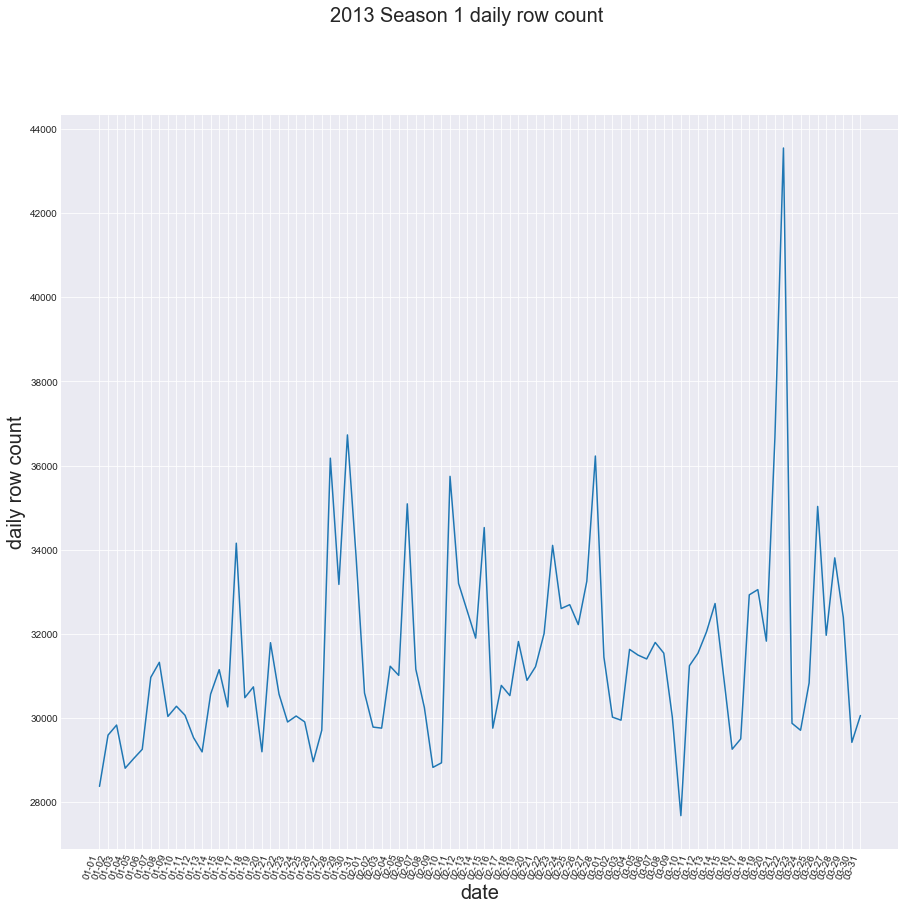

In [442]:
%matplotlib inline
sns.set_style("darkgrid")
fig= plt.figure(figsize=(15,15))
plt.plot(q1_2013['DATE'],q1_2013['COUNT(*)'])
fig.suptitle('2013 Season 1 daily row count',fontsize=20)
plt.xlabel("date",fontsize=20)
plt.ylabel("daily row count",fontsize=20)
fig.autofmt_xdate(bottom=0.2, rotation=70, ha='right')



 ### q2 plot daily busyness

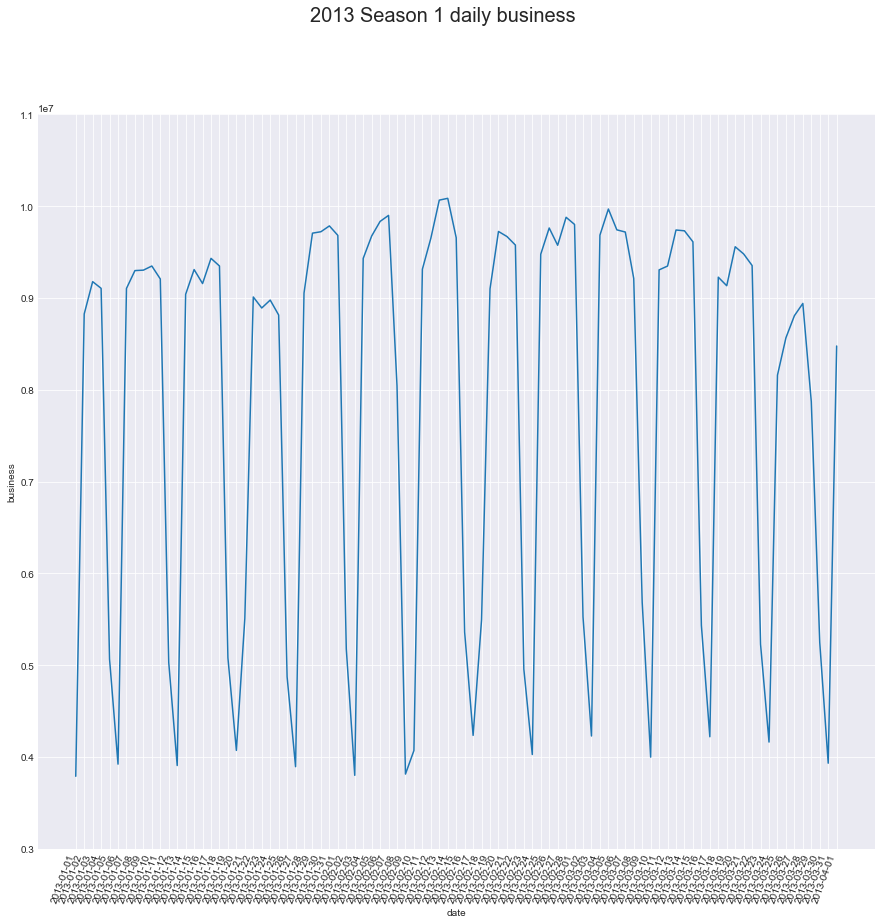

In [358]:
%matplotlib inline
data_2013_df.groupby(['DATE'])['busy'].sum().to_frame().reset_index()
q1_busy=data_2013_df.groupby(['DATE'])['busy'].sum().to_frame().reset_index()
q1_busy=q1_busy.loc[q1_busy['DATE']<='2013-04-01']
sns.set_style("darkgrid")
fig = plt.figure(figsize=(15,15))
plt.plot(q1_busy['DATE'],q1_busy['busy'])
fig.suptitle('2013 Season 1 daily business',fontsize=20)
plt.xlabel('date')
plt.ylabel('business')
plt.ylim([3000000,11000000])
fig.autofmt_xdate(bottom=0.2, rotation=70, ha='right')



 ### q3 plot mean and standard deviation of Penn-station 34st

In [176]:
penn_station_data=data_2013_df.loc[(data_2013_df['DATE']<'2013-04-01')&(data_2013_df['UNIT']=='R012')]
penn_station_monthly_data=penn_station_data.groupby('DATE')['busy'].sum().reset_index()
penn_station_monthly_data['month']=[x[6] for x in penn_station_monthly_data['DATE']]

Text(0,0.5,'busyness')

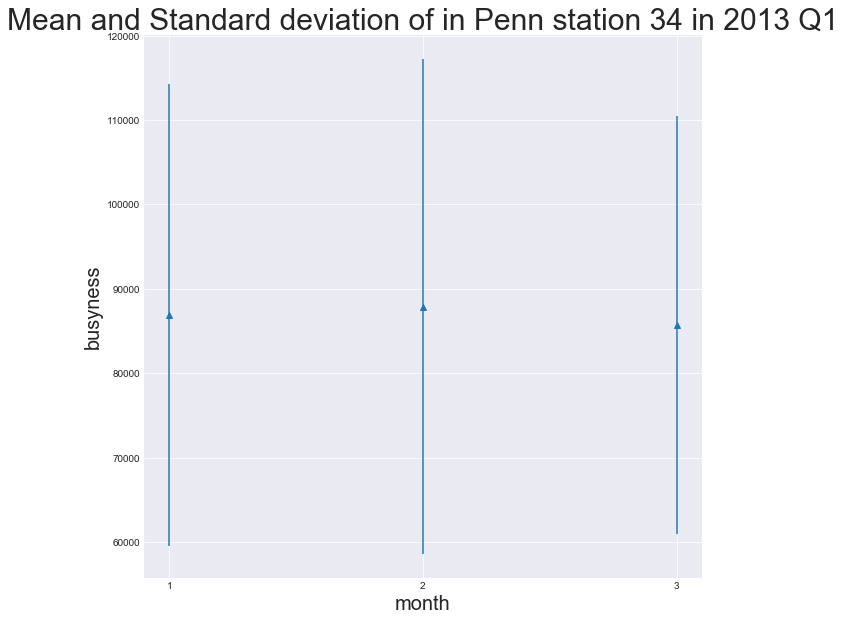

In [197]:
%matplotlib inline

f, ax = plt.subplots(figsize=(10, 10))
penn_station_monthly=penn_station_monthly_data.groupby('month')['busy'].agg([np.mean,np.std]).reset_index()
plt.errorbar(penn_station_monthly['month'], penn_station_monthly['mean'],
             penn_station_monthly['std'], linestyle='None', marker='^')
ax.set_xlabel("month",fontsize=20)
ax.set_title("Mean and Standard deviation of in Penn station 34 in 2013 Q1",fontsize=30)
ax.set_ylabel("busyness",fontsize=20)



 ### q4 quantiles of Penn-station 34st

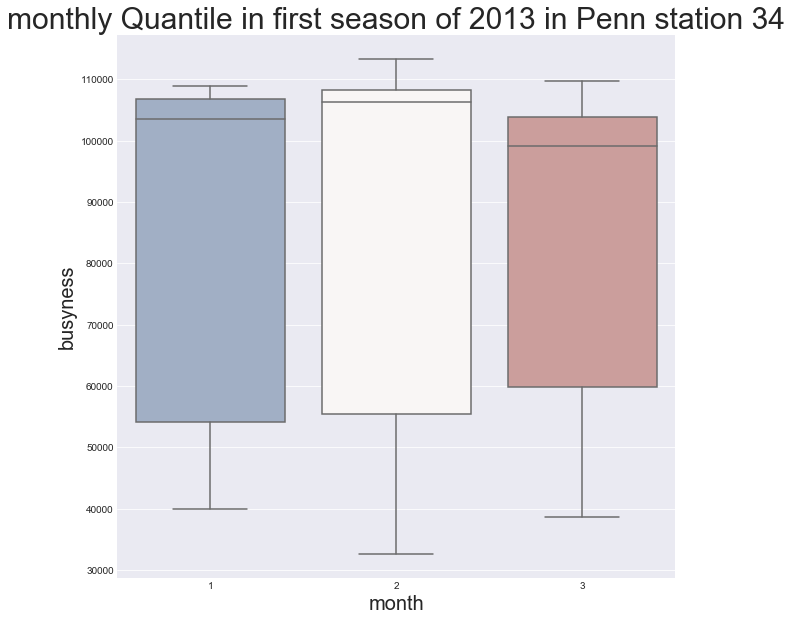

In [198]:
f, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="month", y="busy", data=penn_station_monthly_data,
            whis=np.inf, palette="vlag")
ax.set_xlabel("month",fontsize=20)
ax.set_title("monthly Quantile in first season of 2013 in Penn station 34",fontsize=30)
ax.set_ylabel("busyness",fontsize=20)
print(penn_quantile)

 ### q5 daily closed station

In [428]:
close_df=data_2013_df.loc[(data_2013_df['entrie']==0)&(data_2013_df['exit']==0),:]
close_df=close_df.loc[close_df['DATE']<'2013-04-01',:]



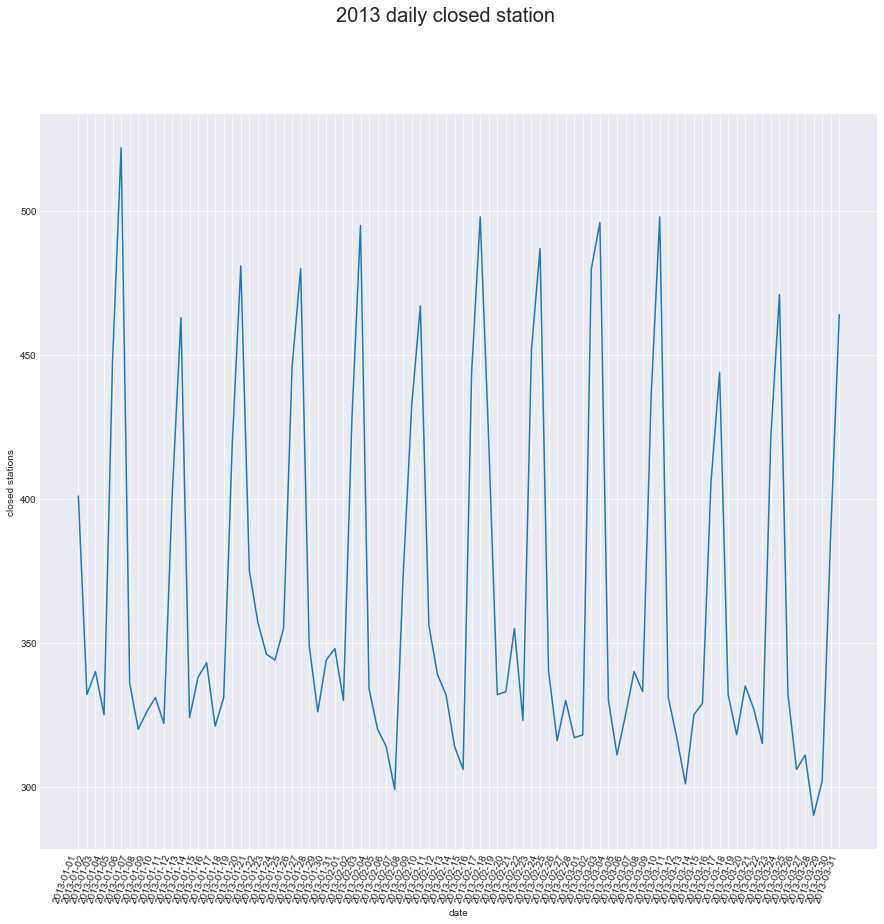

In [429]:
close_df=close_df.groupby('DATE')['CA','UNIT'].count().reset_index()
sns.set_style("darkgrid")
fig = plt.figure(figsize=(15,15))
plt.plot(close_df['DATE'],close_df['UNIT'])
fig.suptitle('2013 daily closed station',fontsize=20)
plt.xlabel('date')
plt.ylabel('closed stations')
fig.autofmt_xdate(bottom=0.2, rotation=70, ha='right')